# HW 4
# David Stanko, Aakash Krishna, Josh Wilkes

## Imports

In [35]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

## Data preprocessing

### Examine the dataset

In [36]:
X = pd.read_csv("enhanced_student_habits_performance_dataset.csv")
X.head()

,student_id,age,gender,major,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,...,screen_time,study_environment,access_to_tutoring,family_income_range,parental_support_level,motivation_level,exam_anxiety_score,learning_style,time_management_score,exam_score
0,100000,26,Male,Computer Science,7.645367,3.0,0.1,Yes,70.3,6.2,...,10.9,Co-Learning Group,Yes,High,9,7,8,Reading,3.0,100
1,100001,28,Male,Arts,5.700000,0.5,0.4,No,88.4,7.2,...,8.3,Co-Learning Group,Yes,Low,7,2,10,Reading,6.0,99
2,100002,17,Male,Arts,2.400000,4.2,0.7,No,82.1,9.2,...,8.0,Library,Yes,High,3,9,6,Kinesthetic,7.6,98
3,100003,27,Other,Psychology,3.400000,4.6,2.3,Yes,79.3,4.2,...,11.7,Co-Learning Group,Yes,Low,5,3,10,Reading,3.2,100
4,100004,25,Female,Business,4.700000,0.8,2.7,Yes,62.9,6.5,...,9.4,Quiet Room,Yes,Medium,9,1,10,Reading,7.1,98


In [37]:
X.shape

(80000, 31)

In [38]:
is_null = pd.isnull(X) # boolean mask of same size as X for whether each value is null
[sum(is_null[i]) for i in X.columns] # see how many missing values there are in each column

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

The raw data has 80,000 rows and 31 columns. There are no missing values.

In [39]:
dtypes = X.dtypes # examine data types
dtypes

student_id                         int64
age                                int64
gender                            object
major                             object
study_hours_per_day              float64
social_media_hours               float64
netflix_hours                    float64
part_time_job                     object
attendance_percentage            float64
sleep_hours                      float64
diet_quality                      object
exercise_frequency                 int64
parental_education_level          object
internet_quality                  object
mental_health_rating             float64
extracurricular_participation     object
previous_gpa                     float64
semester                           int64
stress_level                     float64
dropout_risk                      object
social_activity                    int64
screen_time                      float64
study_environment                 object
access_to_tutoring                object
family_income_ra

We have many categorical variables encoded as strings (e.g.: gender, major, extracurricular_participation), so we have to drop those. However, let's examine all the columns of type `float64`. Some of the `int64` columns might be categorical or unnecessary as well. However, we know any column of type `float64` is continuous numerical data.

In [40]:
categorical_cols = dtypes[dtypes != "float64"].index # get the index of the dtypes series, where the value in the series is not float64
categorical_cols

Index(['student_id', 'age', 'gender', 'major', 'part_time_job', 'diet_quality',
       'exercise_frequency', 'parental_education_level', 'internet_quality',
       'extracurricular_participation', 'semester', 'dropout_risk',
       'social_activity', 'study_environment', 'access_to_tutoring',
       'family_income_range', 'parental_support_level', 'motivation_level',
       'exam_anxiety_score', 'learning_style', 'exam_score'],
      dtype='object')

In [41]:
# Look at the unique values of each non-float column

for col in categorical_cols:
    print(f"\n{'-'*50} {col} {'-'*50}")
    print(f"Unique values: {X[col].unique()}")


-------------------------------------------------- student_id --------------------------------------------------
Unique values: [100000 100001 100002 ... 179997 179998 179999]

-------------------------------------------------- age --------------------------------------------------
Unique values: [26 28 17 27 25 19 16 24 21 22 23 20 18]

-------------------------------------------------- gender --------------------------------------------------
Unique values: ['Male' 'Other' 'Female']

-------------------------------------------------- major --------------------------------------------------
Unique values: ['Computer Science' 'Arts' 'Psychology' 'Business' 'Engineering' 'Biology']

-------------------------------------------------- part_time_job --------------------------------------------------
Unique values: ['Yes' 'No']

-------------------------------------------------- diet_quality --------------------------------------------------
Unique values: ['Poor' 'Good' 'Fair']

---------

Based on context and what the variables represent, we should drop `student_id`, `gender`, `major`, `part_time_job`, `diet_quality`, `parental_education_level`, `internet_quality`, `extracurricular_participation`, `semester`,
                      `dropout_risk`, `study_environment`, `access_to_tutoring`,
                      `family_income_range`, and `learning_style`. We have some variables on a scale of 0-10 or 0-5, like `exercise_frequency` and `social_activity`. Even though those are discrete numerical variables, we think we should keep them because an exercise or social activity frequency of 1.5, for example, is meaningful and interpretable. Ratings like that do not have to be integers.

### Drop categorical variables and other irrelevant variables:

In [42]:
X = X.drop(columns = ["student_id", "gender", "major", "part_time_job",
                      "diet_quality", "exercise_frequency", "parental_education_level",
                      "internet_quality", "extracurricular_participation", "semester",
                      "dropout_risk", "study_environment", "access_to_tutoring",
                      "family_income_range", "learning_style"])

In [43]:
X.head()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,mental_health_rating,previous_gpa,stress_level,social_activity,screen_time,parental_support_level,motivation_level,exam_anxiety_score,time_management_score,exam_score
0,26,7.645367,3.0,0.1,70.3,6.2,6.0,4.00,5.8,0,10.9,9,7,8,3.0,100
1,28,5.700000,0.5,0.4,88.4,7.2,6.8,4.00,5.8,5,8.3,7,2,10,6.0,99
2,17,2.400000,4.2,0.7,82.1,9.2,5.7,3.79,8.0,5,8.0,3,9,6,7.6,98
3,27,3.400000,4.6,2.3,79.3,4.2,8.5,4.00,4.6,3,11.7,5,3,10,3.2,100
4,25,4.700000,0.8,2.7,62.9,6.5,9.2,4.00,5.7,2,9.4,9,1,10,7.1,98


### Scale the data

We will now scale the data to have zero mean and unit variance.

In [44]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns) # scaled dataset
X_scaled.head()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,mental_health_rating,previous_gpa,stress_level,social_activity,screen_time,parental_support_level,motivation_level,exam_anxiety_score,time_management_score,exam_score
0,1.066790,1.731919,0.344972,-1.641677,0.019161,-0.557064,-0.418464,0.858879,0.403204,-1.467026,0.441221,1.225264,0.527057,-0.283052,-0.959906,0.936783
1,1.600758,0.761237,-1.384614,-1.382158,1.063417,0.124429,-0.002138,0.858879,0.403204,1.466762,-0.493744,0.529203,-1.216462,0.830286,0.192381,0.850512
2,-1.336063,-0.885369,1.175173,-1.122639,0.699947,1.487414,-0.574587,0.405191,1.529583,1.466762,-0.601625,-0.862921,1.224465,-1.396390,0.806934,0.764242
3,1.333774,-0.386398,1.451907,0.261462,0.538405,-1.920049,0.882557,0.858879,-0.211185,0.293247,0.728903,-0.166859,-0.867758,0.830286,-0.883087,0.936783
4,0.799807,0.262265,-1.177064,0.607487,-0.407773,-0.352616,1.246843,0.858879,0.352005,-0.293511,-0.098182,1.225264,-1.565166,0.830286,0.614886,0.764242


Matrix Completion

First, we will introduce missing elements into the array in order to check the efficacy of the matrix completion later

In [45]:
np.random.seed(21)
X = X_scaled.to_numpy(copy=True)
missing_elements = int(X.shape[0] * 0.2)

row_index = np.random.choice(X.shape[0], size=missing_elements, replace=False)
column_index = np.random.choice(X.shape[1], size=missing_elements)

Xna = X.copy()
Xna[row_index, column_index] = np.nan


Then, we create a small function to fit a new SVD onto an array

Next, we initialize variables that will replace the missing values with column means and other variables that will be used to track the progress of the iterations that will be used to fit our data

A while loop is formed that will track and iterate fittings of matrix completions using SVD until the relative error becomes better then the threshold value we created earlier

In [46]:
def matrix_completion(X_na, rank=5, max_iter=100, thresh=1e-7):
    X_filled = X_na.copy()
    
    rel_err = 1
    iter_ = 0
    Xhat = Xna.copy()
    xbar = np.nanmean(Xna, axis=0)
    Xhat[row_index, column_index] = xbar[column_index]
    for r, c in zip(row_index, column_index):
        Xhat[r, c] = xbar[c]




    ismiss = np.isnan(Xna)
    Xscaled = (Xna - xbar) / np.sqrt(np.sum(~ismiss, axis=0))
    Xscaled_nomiss = Xscaled[~ismiss]
    mssold = np.mean(np.square(Xscaled_nomiss))
    mss0 = np.mean(np.square(Xna[~ismiss]))

    while rel_err > thresh:
        iter_ += 1
        Xapp = fit_svd(Xhat, M=1)
        Xhat[ismiss] = Xapp[ismiss]
        mss = np.mean(np.square(Xna[~ismiss] - Xapp[~ismiss]))
        rel_err = (mssold - mss) / mss0
        mssold = mss
    
    print(f"Iter: {iter_}, MSS: {mss}, Rel. Err: {rel_err}")
   

    return X_filled

Iter: 1, MSS: 0.8381578577434508, Rel. Err: -0.8381940562743331


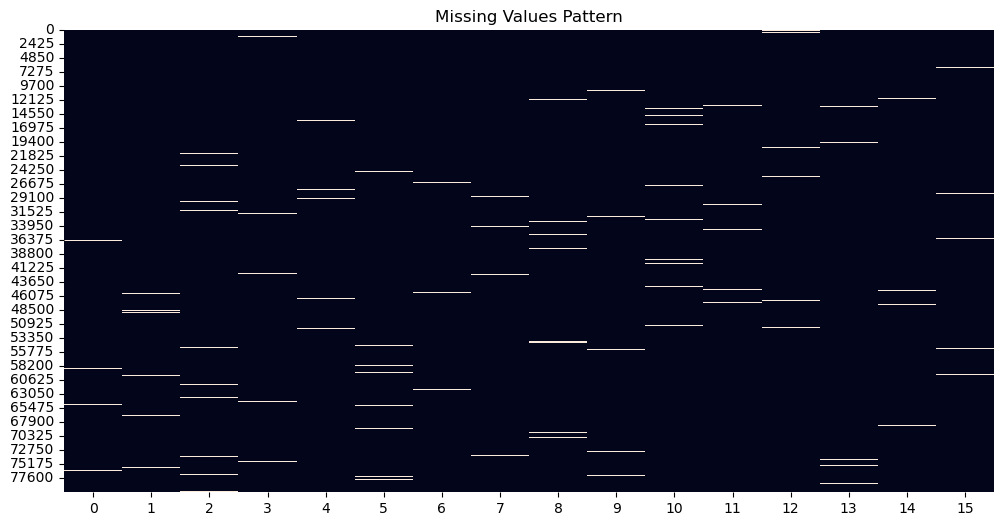

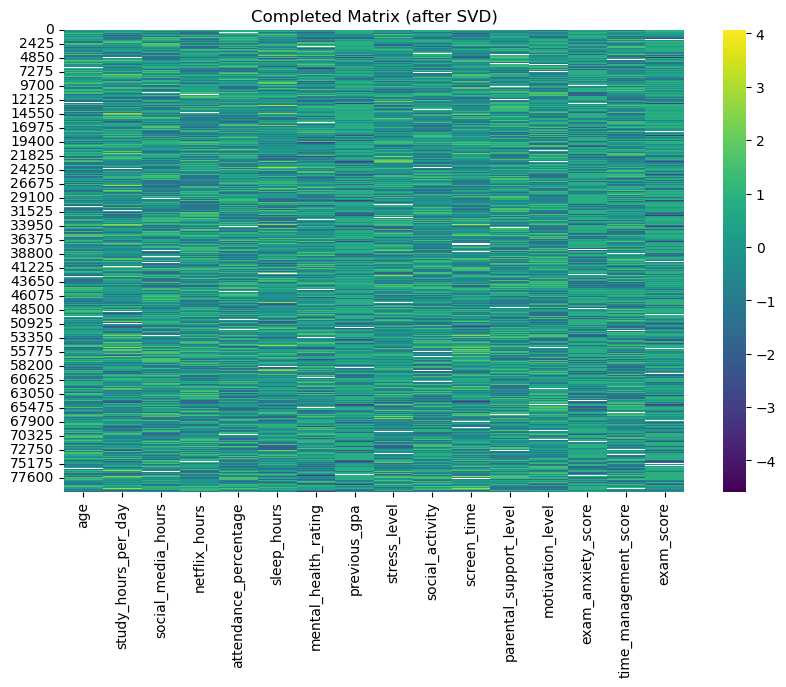

In [47]:
X_completed = matrix_completion(Xna, rank=5)

# Convert back to DataFrame for interpretation
X_completed_df = pd.DataFrame(X_completed, columns=X_scaled.columns)

# Compare histograms or heatmaps before and after
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(pd.DataFrame(Xna).isna(), cbar=False)
plt.title("Missing Values Pattern")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(X_completed_df, cmap="viridis")
plt.title("Completed Matrix (after SVD)")
plt.show()
